## Векторные представления слов

Векторные представления слов (или embeddings) - это наборы чисел, которые должны как-то отражать смысл/значение слов. Формально значение определить очень сложно, поэтому в NLP используются очень упрощенные и утилитарные подходы к пониманию значения. Например, можно считать, что векторные представления хорошо передают смысл слов, если близость (по какой-то выбранной метрике) между похожими словами большая, а между противоположными - большая. Другой пример - с помощью векторных представлений получается хорошо решить задачу, которая требует понимания смысла (т.е. почти любую NLP задачу), значит эти векторные представления хорошо кодируют смысл. 

Есть еще такие тонкости как многозначность и зависимость смысла от контекста, но это уже сильно сложнее и мы оставим их на следующие семинары, а пока просто полностью проигнорируем. К тому же, как и с мешком слов, часто упрощенного подхода будет достаточно.

Единственная окололингвистическая теоретическая часть, о которой стоит сказать это дистрибутивная гипотеза. Она состоит в том, что лингвистические единицы, встречающиеся в схожих контекстах, имеют близкие значения. Обычно в научных статьях цитируют John Firth (Ферс) - '*You shall know a word by the company it keeps*' (Firth, J. R. 1957:11) 
Также в "Филосовских исследованиях" Витгенштейна есть такое -  *“For a large class of cases—though not for all—in which we employ the word ‘meaning’ it can be defined thus: **the meaning of a word is its use in the language.**”* (1951)

Саму область иногда называют дистрибутивная семантика.

Давайте посмотрим, как можно строить векторные представления слов.

In [267]:
import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

### Матричные выражения 

Для начала вспомним матричные разложения. В двух методах, которые мы использовали для тематического моделирования одна из матриц была размерности (количество слов в словаре, количество тем), т.е. каждую строчку в этой матрице можно рассматривать как векторное представление слова! Давайте разложим матрицу документы-слова, собранную по википедии и посмотрим на близость векторов слов.

In [268]:
# на картинке TruncatedSVD
Image(url="https://gcdn.pbrd.co/images/YcZxyZhQGrUC.png?o=1",
     width=1000, height=900)

In [269]:
# в нашем корпусе 20к текстов
wiki = open('wiki_data.txt').read().split('\n')

In [270]:
len(wiki)

20003

In [271]:
cv = CountVectorizer(max_features=10000)
svd = TruncatedSVD(200)

X = cv.fit_transform(wiki)
X_svd = svd.fit_transform(X)

Получившаяся матрица X нас не интересует. Нам нужно вытащить матрицу U, она лежит в svd.components_

In [272]:
# изначально U размерности (темы, слова) и для удобства ее нужно перевернуть - транспонировать
embeddings = svd.components_.T

In [273]:
embeddings.shape

(10000, 200)

Теперь вытаскиваем соответствия слов индексам и наоборот

In [274]:
id2word = cv.get_feature_names_out()
word2id = {word:i for i,word in enumerate(id2word)}

In [280]:
word2id['птица']

7070

Напишем простую функцию, которая для заданного слова найдет ближайшие ему слова в матрице

In [11]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in 
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

Испытаем ее на нескольких рандомных словах

In [12]:
most_similar('птица', embeddings)

['птица',
 'самцы',
 'самцов',
 'птицы',
 'самки',
 'самка',
 'самок',
 'длины',
 'питается',
 'жуки']

In [13]:
most_similar('церковь', embeddings)

['церковь',
 'чудотворца',
 'каменная',
 'храм',
 'прихожан',
 'храма',
 'богослужения',
 'орла',
 'деревянная',
 'святителя']

In [14]:
most_similar('москва', embeddings)

['москва',
 'выставка',
 'арт',
 'галерея',
 'центральный',
 'выставке',
 'выставках',
 'галерее',
 'художника',
 'постоянная']

Кажется, что получается неплохо. 

Но матричные разложения для этой задачи обычно не применяют. Основной метод для создания векторых представлений слов - это word2vec и его улучшение fastext. 

## Word2Vec

Word2Vec был создан в 2013 году в Google командой под руководством Tomas Mikolov. 

Он был описан в двух статьях: 
1) https://arxiv.org/abs/1301.3781   
2) https://aclanthology.org/N13-1090/

Главным достоинством word2vec была его эффективность (и по скорости и по потреблению ресурсов), что с одной строны позволило большим компаниям обучить модели на огромных корпусах, а с другой дало возможность отдельным исследователям строить качественные специфичные модели (например, на корпусе научных статей по математике), используя небольшие сервера или вообще личные компьютеры. 

Следующие несколько лет конференции были забиты статьями, рассматривающими word2vec со всех возможных сторон.

Сейчас word2vec уже конечно устарел, транформерные модели лучше. Но бейзлайн все еще очень хороший. К тому же с развитием процессоров он стал еще быстрее.

В Word2Vec очень много деталей и оптимизаций, поэтому использовать лучше готовую реализацию (ниже мы это сделаем через gensim). Но для понимания мы попробуем его воспроизвести на tensorflow, параллельно разобрав базовые вещи в deep learning.

Для начала нам нужно построить словарь.

Предобработка нам не так важна. Главное - получить из текстов токены.

In [282]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

Лучше сразу посчитать количество упоминаний, чтобы отсеять самые редкие.

In [283]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

почти 300к слов - это многовато

In [284]:
len(vocab)

533408

Возьмем только те, что встретились больше 30 раз.

In [285]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [286]:
len(filtered_vocab)

16310

~15к - уже нормальная цифра

Теперь нам нужно заменить в каждом тексте слова на числа (индексы в словаре). 

Создадим для этого специальный словарь с индексами. В этот словарь нам нужно положить дополнительный токен - PAD (чуть ниже станет понятнее)

In [287]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [288]:
id2word = {i:word for word, i in word2id.items()}

Заменяем слова на индексы.

In [295]:

sentences = []

for text in wiki:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

Далее нужно преобразовать токенизированные тексты в формат для обучения. 

### Skip Gram

In [265]:
Image(url="https://leimao.github.io/images/article/2019-08-23-Word2Vec-Classic/word2vec.png",
     width=600, height=600)

Word2Vec состоит из двух моделей skip gram и CBOW (continuos bag of words). В обоих алгоритмах происходит итерирование по кусочкам текстов фиксированной длинны (окнам). В каждом окне выбирается центральное целевое слово (target), а слова слева и справа от него считаются контекстом (context). В Skip-gram модель обучается по целевому слову предсказывать контекстные слова, а в CBOW по контексту предсказывается целевое слово. 

Давайте соберем датасет для skip gram. Датасетом будут просто пары - (целевое слово, контекстное слово). 

In [305]:
# skip gram
X = []
y = []

window = 5
for sent in sentences[:1000]:
    for i in range(len(sent)-1):
        word = sent[i] # target
        # слова до и после целевого
        # в начале и в конце окно будет неполным, но это не страшно
        context = sent[max(0, i-window):i] + sent[i+1:i+window] 

        for context_word in context:
            X.append(word)
            y.append(context_word)


In [302]:
X[1], y[1]

(11605, 12656)

In [26]:
len(X), len(y)

(1683454, 1683454)

Как и в любой задаче машинниого обучения нужно тестироваться на отложенной выборке

In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

### Создаем нейронную сеть

Для введения в нейронные сети посмотрите:
1) серию видео на канале 3blue1brown - https://www.youtube.com/watch?v=aircAruvnKk  
2) лекцию курса dlcoure.ai - https://www.youtube.com/watch?v=kWTC1NvL894

Word2Vec можно рассматривать как очень маленькую нейронную сеть - тут всего 1 слой. Сама задача сводится к многоклассой классификации. На вход мы получаем индекс слова, преобразуем его в векторное представление, 

В tf.keras два способа построения моделей: Sequential и Functional. В первом мы как будто создаем список и добавляем в него слои, а во втором вручную применяем каждый слой к результату предыдущего слоя.

Соберем нейронную сеть первым способом.

In [28]:
# инициализируем модель
# это что-то типа model = [] 
model = tf.keras.Sequential()

# первым добавляем эмбединг слой
# он каждому слову (его индексу) сопоставит вектор заданой размерности
# также нам нужно передать параметры нашей выборки - размер словаря (input_dim) и длину текста (input_length)
# в нашем случае мы подаем только 1 слово поэтому длина - 1
model.add(tf.keras.layers.Embedding(input_dim=len(word2id), 
                                    input_length=1, 
                                    output_dim=100)) # также указываем желаемый размер эмбединга

# на выходе из Embedding мы получим массив размерности (1, 100)
# единичная размерность нам не нужна и ее можно схлопнуть
# это можно сделать специальным слоем которые называется Flatten
# чтобы было понятнее, вот пример на списках
# флаттен делает что-то такое
# [[1], [2], [3]] -> [1, 2, 3]
model.add(tf.keras.layers.Flatten()) 

# И теперь 1 реальный слой, который называется полносвязным
# Полносвязный слой это матрица, применение полносвязного слоя - это умножение на эту матрицу
# В полносвязном слое нужно указать количество чисел которое мы хотим получить на выходе
# в нашем случае мы хотим получить по 1 числу на 1 слово в словаре
# это число будет соответствовать вероятности предсказания этого слова
# На входе у нас вектор 1 слова, а умножение вектора на матрицу можно интепретировать как нахождение близости
# с каждым элементом матрицы; т.е. мы берем эмбединг и находим близость с эмбедингами всех других слов в словаре

# По умолчанию полносвязный слой не выдает вероятности, чтобы их получить нужно использовать softmax
# Софтмакс - это одна из функций активации
# Функции аквтивации преобразуют числа каким-то нелинейным способом, которого не добьешься обычным умножением на матрицу
# сочетание линейных операций с матрицами и векторами и нелинейных функций - это то что делает нейронные сети такими мощными
model.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))

# компилируем модель
# выбираем лосс - функция, по которой модель будет оценивать качество и обновлять веса
# для классификации стандартно используется categorical_crossentropy
# У нас стоит sparse_categorical_crossentropy потому что мы подаем индексы, а по умолчанию нужно подавать 
# one-hot векторы или вероятности

# выбираем оптимизатор - он влияет на то, как будет обновляться модель 
# (подробнее вот тут - 
# https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3 ).
# По умолчанию можно ставить adam и менять только learning_rate

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), 
              loss='sparse_categorical_crossentropy',
              
              )

2022-01-12 11:59:46.595279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 11:59:46.613799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 11:59:46.614564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 11:59:46.615993: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Можно посмотреть на размерности, которые будут получаться после каждого слоя

In [29]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 100)            1631100   
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 16311)             1647411   
                                                                 
Total params: 3,278,511
Trainable params: 3,278,511
Non-trainable params: 0
_________________________________________________________________
None


Осталось только обучить

In [30]:
# нейронные сети обучаются не на всех данных сразу
# а по кусочкам (батчам)
# размер батча зависит от размера нейронной сети и ресурсов
# обычно это значение от 4 до нескольких тысяч
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000, 
         epochs=10)

Epoch 1/10
1600/1600 [==============================] - 8s 5ms/step - loss: 7.8727 - val_loss: 7.5314
Epoch 2/10
1600/1600 [==============================] - 7s 4ms/step - loss: 7.4530 - val_loss: 7.4054
Epoch 3/10
1600/1600 [==============================] - 7s 4ms/step - loss: 7.3080 - val_loss: 7.3006
Epoch 4/10
1600/1600 [==============================] - 7s 4ms/step - loss: 7.1780 - val_loss: 7.2240
Epoch 5/10
1600/1600 [==============================] - 7s 4ms/step - loss: 7.0605 - val_loss: 7.1654
Epoch 6/10
1600/1600 [==============================] - 7s 4ms/step - loss: 6.9522 - val_loss: 7.1200
Epoch 7/10
1600/1600 [==============================] - 7s 4ms/step - loss: 6.8514 - val_loss: 7.0869
Epoch 8/10
1600/1600 [==============================] - 7s 4ms/step - loss: 6.7579 - val_loss: 7.0638
Epoch 9/10
1600/1600 [==============================] - 7s 4ms/step - loss: 6.6715 - val_loss: 7.0516
Epoch 10/10
1600/1600 [==============================] - 7s 4ms/step - loss: 6.593

Посмотрим на графики функции потерь. Она должна уменьшаться и на трейне и на тесте

dict_keys(['loss', 'val_loss'])


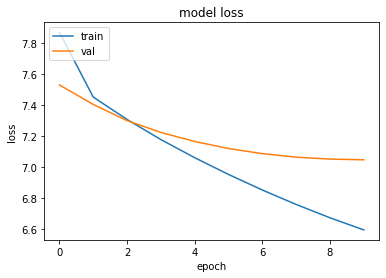

In [31]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Но нас интересует не сама задача классификации, а получившиеся векторные представления.

У нас есть два слоя с матрицами размера (длина словаря, 100). Можно взять векторные представления из любого из этих слоев или взять усредненный вектор.

In [32]:
model.layers

In [33]:
# веса embedding слоя
model.layers[0].get_weights()[0].shape

(16311, 100)

In [34]:
# веса полносвязного слоя
model.layers[2].get_weights()[0].shape

(100, 16311)

In [35]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T

In [36]:
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [37]:
embeddings.shape

(16311, 100)

In [40]:
most_similar('птица', embeddings)

['птица',
 'небольшая',
 'влажных',
 'многолетнее',
 'травянистое',
 'высотой',
 'семенами',
 'длиной',
 'коротким',
 'бутоны']

In [41]:
most_similar('церковь', embeddings)

['церковь',
 'иисуса',
 'деревянная',
 'устроена',
 'собор',
 'построенная',
 'значительным',
 'петра',
 'павла',
 'башня']

### CBOW


Теперь попробуем CBOW. В нем нужно по контексту предсказать целевое слово. В отличие от skip-gram тут сразу используется весь контекст, а векторы слов в контексте усредняются в 1 вектор контекста.

Собрать датасет очень просто.

In [316]:

X = []
y = []

window = 5
for sent in sentences[:10000]:
    for i in range(len(sent)-1):
        word = sent[i]
        context = sent[max(0, i-window):i] + sent[i+1:i+window]
        
        X.append(context)
        y.append(word)


Но нужно его немного поправить. В начале и конце текстов окна будут не полные и соответственно длина контекста будет не одинаковая. Но для преобразования в массив, длины должны быть одинаковыми. Решение этой проблемы - паддинг, добавление недостающего количества нулей  (может быть и другой индекс, но чаще всего именно 0). 

In [308]:
# оригинальные контексты
X[:10]

[[6444, 12656, 7765, 2950],
 [11605, 12656, 7765, 2950, 7540],
 [11605, 6444, 7765, 2950, 7540, 3322],
 [11605, 6444, 12656, 2950, 7540, 3322, 12438],
 [11605, 6444, 12656, 7765, 7540, 3322, 12438, 7765],
 [11605, 6444, 12656, 7765, 2950, 3322, 12438, 7765, 11689],
 [6444, 12656, 7765, 2950, 7540, 12438, 7765, 11689, 1881],
 [12656, 7765, 2950, 7540, 3322, 7765, 11689, 1881, 7765],
 [7765, 2950, 7540, 3322, 12438, 11689, 1881, 7765, 2200],
 [2950, 7540, 3322, 12438, 7765, 1881, 7765, 2200, 12905]]

In [311]:
np.array(X[:10])

/Users/mnefedov/.pyenv/versions/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


array([list([6444, 12656, 7765, 2950]),
       list([11605, 12656, 7765, 2950, 7540]),
       list([11605, 6444, 7765, 2950, 7540, 3322]),
       list([11605, 6444, 12656, 2950, 7540, 3322, 12438]),
       list([11605, 6444, 12656, 7765, 7540, 3322, 12438, 7765]),
       list([11605, 6444, 12656, 7765, 2950, 3322, 12438, 7765, 11689]),
       list([6444, 12656, 7765, 2950, 7540, 12438, 7765, 11689, 1881]),
       list([12656, 7765, 2950, 7540, 3322, 7765, 11689, 1881, 7765]),
       list([7765, 2950, 7540, 3322, 12438, 11689, 1881, 7765, 2200]),
       list([2950, 7540, 3322, 12438, 7765, 1881, 7765, 2200, 12905])],
      dtype=object)

In [317]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=10, padding='post')
y = np.array(y)

In [318]:
# контексты после паддинга
X

array([[ 6444, 12656,  7765, ...,     0,     0,     0],
       [11605, 12656,  7765, ...,     0,     0,     0],
       [11605,  6444,  7765, ...,     0,     0,     0],
       ...,
       [13508,  5846, 13204, ...,  5200,     0,     0],
       [ 5846, 13204,  7765, ...,     0,     0,     0],
       [13204,  7765,  5045, ...,     0,     0,     0]], dtype=int32)

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Сама модель почти полностью совпадает

In [57]:
model = tf.keras.Sequential()

# 1 отличие - то что на вход подается не 1 слово а целое окно контекста
# но на уровне embedding слоя нужно изменить только input_length
# она будет равна числу до которого мы делали паддинг
model.add(tf.keras.layers.Embedding(input_dim=len(word2id), 
                                    input_length=10, 
                                    output_dim=100))

# 2 отличие - нужно усреднить контекст в 1 вектор
model.add(tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1)))

model.add(tf.keras.layers.Dense(len(word2id), activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy',
              
              )

In [58]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 100)           1631100   
                                                                 
 lambda_3 (Lambda)           (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 16311)             1647411   
                                                                 
Total params: 3,278,511
Trainable params: 3,278,511
Non-trainable params: 0
_________________________________________________________________
None


In [59]:

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=5)

Epoch 1/5
1653/1653 [==============================] - 8s 5ms/step - loss: 7.1693 - val_loss: 6.6003
Epoch 2/5
1653/1653 [==============================] - 7s 5ms/step - loss: 6.2509 - val_loss: 6.1478
Epoch 3/5
1653/1653 [==============================] - 7s 5ms/step - loss: 5.8232 - val_loss: 5.9535
Epoch 4/5
1653/1653 [==============================] - 8s 5ms/step - loss: 5.5460 - val_loss: 5.8524
Epoch 5/5
1653/1653 [==============================] - 8s 5ms/step - loss: 5.3367 - val_loss: 5.8009


In [60]:
embeddings_1 = model.layers[0].get_weights()[0]
embeddings_2 = model.layers[2].get_weights()[0].T
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [61]:
embeddings = np.mean([embeddings_1, embeddings_2], axis=0)

In [62]:
embeddings.shape

(16311, 100)

In [63]:
most_similar('птица', embeddings)

['птица',
 'рыба',
 'жук',
 'обыкновенная',
 'чёрная',
 'кустарников',
 'растениями',
 'птиц',
 'змея',
 'дерево']

### Negative sampling

Одна из основных оптимизаций в word2vec - negative sampling. Задача из многоклассовой классификации преобразуется в бинарную классификацию. На вход подается сразу и целевое слово и контекст, а на выходе ожидается вероятность того, что они употребляются вместе. Положительные примеры просто берутся из корпуса, а для того, чтобы собрать негативные примеры, из словаря просто случайно выбираются слова. Возможна ситуация, когда для контекста случайно выбранное слово на самом деле может встретиться в этом контексте, но за счет большого количества примеров, такие неточности не повлияют на итоговый результат.

В этот раз не будем сразу генерировать весь датасет. Он получается очень большой и эффективнее генерировать примеры на ходу (т.е. использовать генератор)

In [64]:
vocab_size = len(id2word)

Эта функция просто генерирует обучающее примеры батчами. В tf генераторы можно напрямую модавать в fit модели

In [66]:
# skip gram
def gen_batches_sg(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)
                    
                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)
                    
                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []


In [67]:
# # cbow 
def gen_batches_cbow(sentences, window = 5, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-window):i] + sent[i+1:i+window]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window*2)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

Саму модель нужно уже задать через Functional API, т.к. у нас будет два входа

In [69]:
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])




In [70]:
model.fit(gen_batches_sg(sentences[:19000], window=5),
          validation_data=gen_batches_sg(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
10000/10000 [==============================] - 36s 4ms/step - loss: 0.4739 - accuracy: 0.7793 - val_loss: 0.5272 - val_accuracy: 0.7593
Epoch 2/2
10000/10000 [==============================] - 36s 4ms/step - loss: 0.4507 - accuracy: 0.7962 - val_loss: 0.4690 - val_accuracy: 0.7889


In [73]:
embeddings = model.layers[2].get_weights()[0]

In [75]:
most_similar('церковь', embeddings)

['церковь',
 'храм',
 'построена',
 'монастыря',
 'монастырь',
 'святого',
 'каменный',
 'собора',
 'деревянная',
 'николая']

In [76]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))


embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model = tf.keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [79]:
model.fit(gen_batches_cbow(sentences[:19000], window=5),
          validation_data=gen_batches_cbow(sentences[19000:],  window=5),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
         epochs=2)

Epoch 1/2
5000/5000 [==============================] - 22s 4ms/step - loss: 0.3447 - accuracy: 0.8503 - val_loss: 0.2899 - val_accuracy: 0.8804
Epoch 2/2
5000/5000 [==============================] - 21s 4ms/step - loss: 0.2521 - accuracy: 0.8954 - val_loss: 0.2626 - val_accuracy: 0.8925


In [80]:
embeddings = model.layers[2].get_weights()[0]

In [81]:
most_similar('семья', embeddings)

['семья',
 'переехала',
 'родители',
 'уехала',
 'жила',
 'рос',
 'сестра',
 'мать',
 'проживала',
 'едет']

In [82]:
most_similar('церковь', embeddings)

['церковь',
 'храм',
 'церкви',
 'храма',
 'монастыря',
 'собор',
 'часовня',
 'здание',
 'колокольня',
 'святого']

Другая значимая оптимизация в word2vec - это иерархический софтмакс. Когда мы считали модель без негативного семплирования, то у нас был большой полносвязный слой с софтмаксом. Иерархический софтмакс упрощает расчеты в этом слое, но его уже так просто не воспроизведешь.

На этом месте уже лучше перейти к готовой реализации.

## Word2Vec в gensim

В gensim есть питоновская обертка к оригинальному ворд2веку, которой очень удобно пользоваться.

In [321]:
import gensim

На вход нужно подавать список списков (токенизированный текст)

In [322]:
wiki = open('wiki_data.txt').read().split('\n')

In [323]:
texts = [preprocess(text) for text in wiki]

In [320]:
# f = open('corpus.txt', 'w')
# for text in texts:
#     f.write(' '.join(text) + '\n')
# f.close()

In [319]:
# corpus = gensim.models.word2vec.LineSentence('corpus.txt', )

В саму модель нужно передать корпус для обучения, для остальных параметров есть значения по умолчанию

In [167]:
%%time
w2v = gensim.models.Word2Vec(texts)

CPU times: user 39.5 s, sys: 207 ms, total: 39.7 s
Wall time: 15.4 s


In [165]:
w2v.wv.most_similar('церковь')

[('часовня', 0.8743033409118652),
 ('построена', 0.8359026312828064),
 ('богородицы', 0.8297877311706543),
 ('православная', 0.8275739550590515),
 ('деревянная', 0.8258281946182251),
 ('храм', 0.8068298697471619),
 ('икона', 0.8052462339401245),
 ('пресвятой', 0.8045442700386047),
 ('божией', 0.7889246940612793),
 ('успения', 0.7842323184013367)]

Давайте теперь разберемся с параметрами:

**vector_size** - размер вектора, обычно используют значение 100-1000  

**min_count** - минимальная частота слова в корпусе (выше мы тоже фильтровали по частототе 30)  

**max_vocab_size** - максимальный размер словаря

**window** - размер окна (выше мы использовали значение 10)

**epochs** - количество эпох (полных итераций по корпусу)

In [178]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             vector_size=300, 
                             min_count=30, 
                             max_vocab_size=10000,
                             window=5,
                             epochs=7)

CPU times: user 24.6 s, sys: 248 ms, total: 24.9 s
Wall time: 9.36 s


In [179]:
w2v.wv.most_similar('церковь')

[('храм', 0.7513039112091064),
 ('собор', 0.6645839214324951),
 ('храма', 0.6581066846847534),
 ('церкви', 0.6571823358535767),
 ('монастырь', 0.644494354724884),
 ('монастыря', 0.6430743336677551),
 ('святого', 0.6364166736602783),
 ('святой', 0.6202442049980164),
 ('собора', 0.6182669401168823),
 ('николая', 0.5432458519935608)]

CBOW или Skip-gram выбираются через параметр **sg** - 1 это skip-gram, а 0 - cbow (по умолчанию всегда cbow)

In [180]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300, 
                             min_count=30, 
                             max_vocab_size=10000,
                             window=5,
                             epochs=7,
                             sg=1
                            )

CPU times: user 1min 23s, sys: 581 ms, total: 1min 23s
Wall time: 28.7 s


Скип-грам обучается значительно дольше 

In [181]:
w2v.wv.most_similar('церковь')

[('храм', 0.6266138553619385),
 ('храма', 0.5525968074798584),
 ('собор', 0.5485511422157288),
 ('церкви', 0.5410593152046204),
 ('монастыря', 0.5160554647445679),
 ('монастырь', 0.5113397836685181),
 ('собора', 0.4808449149131775),
 ('здание', 0.4742560088634491),
 ('святого', 0.4521041512489319),
 ('николая', 0.4474599063396454)]

Увеличения window на cbow практически не влияет

In [182]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300, 
                             min_count=30, 
                             max_vocab_size=10000,
                             window=10,
                             epochs=7,
                             
                            )

CPU times: user 28.8 s, sys: 252 ms, total: 29.1 s
Wall time: 10.8 s


А вот skip-gram сильно замедляется с увеличением окна

In [183]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=300, 
                             min_count=30, 
                             max_vocab_size=10000,
                             window=10,
                             epochs=7,
                             sg=1
                            )

CPU times: user 2min 25s, sys: 491 ms, total: 2min 25s
Wall time: 49.7 s


Выбор между negative_sampling и hierarchical softmax осуществляется через 2 параметра **hs** и **negative**:   
1) **hs=0, negative=0** - ни то ни другое не используется  
2) **hs=1** - используется hierarchical softmax  
3) **hs=0, negative > 0** - используется negative_sampling и число в negative указывает сколько негативных примеров семплировать (в документации советуют значения от 5 до 20)  (по умолчанию)   

In [170]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             hs=0,
                             negative=0
                            )

CPU times: user 8.99 s, sys: 185 ms, total: 9.18 s
Wall time: 9 s


Работает быстрее, но качество сильно страдает

In [171]:
w2v.wv.most_similar('церковь')

[('спрятан', 0.42304709553718567),
 ('железную', 0.4164682626724243),
 ('краёв', 0.4125758111476898),
 ('жизненную', 0.40853172540664673),
 ('интерфейсом', 0.4083697497844696),
 ('понижении', 0.4059951603412628),
 ('откладывать', 0.3957667648792267),
 ('ленинградскую', 0.3870789408683777),
 ('36', 0.381250262260437),
 ('архангельского', 0.37584179639816284)]

Иерархический софтмакс работает сильно дольше

In [172]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             hs=1
                            )

CPU times: user 1min 25s, sys: 342 ms, total: 1min 25s
Wall time: 33 s


In [173]:
w2v.wv.most_similar('церковь')

[('часовня', 0.7753229141235352),
 ('храм', 0.7011154890060425),
 ('колокольня', 0.6815000772476196),
 ('деревянная', 0.6767951250076294),
 ('построенная', 0.6744670271873474),
 ('церкви', 0.6732568740844727),
 ('икона', 0.6712637543678284),
 ('храма', 0.6560209393501282),
 ('построена', 0.6511436700820923),
 ('монастыре', 0.6485512852668762)]

Дефолтная настройка работает достаточно быстро и хорошо

In [174]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             hs=0,
                             negative=5
                            )

CPU times: user 40.7 s, sys: 238 ms, total: 40.9 s
Wall time: 15.9 s


In [175]:
w2v.wv.most_similar('церковь')

[('часовня', 0.8404061794281006),
 ('православная', 0.8251654505729675),
 ('построена', 0.8183906674385071),
 ('деревянная', 0.8111212849617004),
 ('богородицы', 0.8039596676826477),
 ('храм', 0.8038241267204285),
 ('икона', 0.7885087132453918),
 ('пресвятой', 0.7846370339393616),
 ('монастырь', 0.7819284796714783),
 ('чудотворца', 0.7770885229110718)]

Повышение negative влияет на время обучения

In [176]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             hs=0,
                             negative=20
                            )

CPU times: user 1min 39s, sys: 348 ms, total: 1min 40s
Wall time: 35.6 s


In [177]:
w2v.wv.most_similar('церковь')

[('часовня', 0.857257604598999),
 ('деревянная', 0.8246216177940369),
 ('построена', 0.8122153282165527),
 ('храм', 0.8049266934394836),
 ('богородицы', 0.7839708924293518),
 ('построенная', 0.772368848323822),
 ('православная', 0.7637260556221008),
 ('храме', 0.7629793882369995),
 ('монастырь', 0.7567533254623413),
 ('каменная', 0.7556505799293518)]

Есть еще несколько параметров, но уже не таких влиятельных:

1) **sample** - отвечает за downsampling частотных слов; чем меньше, тем сильнее штрафуются частотные слова (по умолчанию стоит 1e-3, но можно поставить 1e-4, 1e-5). Для sg это будет значительно влиять на скорость (1e-5 будет быстрее)  
2) **ns_exponent** -  регулирет downsampling частотных слов в negative sampling; 0 - никакого штрафа за частотность (как у нас выше с полным рандомом), 1 - штрафует пропорционально частотности, значения 0-1 что-то посередине (по умолчанию стоит 0.75)  
3) **cbow_mean** - отвечает за функцию агрегации в cbow; 1 - это среднее, 0 - сумма (у нас выше среднее, оно же стоит по умолчанию)  

In [190]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             sample=1e-5,
                             sg=1
                            )

CPU times: user 1min 29s, sys: 345 ms, total: 1min 29s
Wall time: 32.3 s


In [191]:
w2v.wv.most_similar('церковь')

[('храм', 0.9693702459335327),
 ('часовня', 0.9608985781669617),
 ('храма', 0.9532955884933472),
 ('храме', 0.9456794261932373),
 ('деревянная', 0.9453122615814209),
 ('рождества', 0.9441068172454834),
 ('монастыря', 0.9335580468177795),
 ('чудотворца', 0.9319661855697632),
 ('богородицы', 0.9289035201072693),
 ('деревянный', 0.9278043508529663)]

In [192]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             ns_exponent=0.84
                            )

CPU times: user 40.7 s, sys: 254 ms, total: 40.9 s
Wall time: 16 s


In [193]:
w2v.wv.most_similar('церковь')

[('часовня', 0.8298123478889465),
 ('храм', 0.8118749856948853),
 ('построена', 0.7992591261863708),
 ('деревянная', 0.7960627675056458),
 ('монастыря', 0.7658997774124146),
 ('монастырь', 0.7656899094581604),
 ('богородицы', 0.7621358036994934),
 ('православная', 0.76121985912323),
 ('церкви', 0.7610598802566528),
 ('собор', 0.7493856549263)]

In [195]:
%%time
w2v = gensim.models.Word2Vec(texts, 
                             cbow_mean=0
                            )

CPU times: user 40.8 s, sys: 232 ms, total: 41 s
Wall time: 16 s


In [196]:
w2v.wv.most_similar('церковь')

[('православная', 0.9259366393089294),
 ('деревянная', 0.9255096912384033),
 ('богородицы', 0.9177859425544739),
 ('пресвятой', 0.9164575934410095),
 ('построена', 0.9148902893066406),
 ('община', 0.9139506220817566),
 ('икона', 0.9081771969795227),
 ('часовня', 0.9020712375640869),
 ('рождества', 0.8993982672691345),
 ('епархия', 0.8981451988220215)]

## FastText

В 2015 почти та же команда выпустила улучшение - FastText (статья - https://arxiv.org/abs/1607.04606). Главная доработка в нем - использование символьных нграммов. В оригинальном word2vec словарь обучается вначале и фиксируется, добавлять новые слова к обученной модели нельзя. Соответственно, если слова нет в словаре, то и вектора для него не будет.

В FastText каждое слово дополнительно разбивается на символьные нграммы и для каждого символьного нграмма тоже есть свой отдельный эмбеддинг. При предсказании векторы символьных нграммов и целого слова усредняются в 1 вектор. В дальнейшем это позволяет генерировать векторы для слов, которых нет в изначальном словаре. Нужно только чтобы новое слово состояло уже из известных символьных нграмм.

Интерфейс обучения и большинство параметров - точно такие же

In [197]:
%%time
ft = gensim.models.FastText(texts)

CPU times: user 2min 56s, sys: 667 ms, total: 2min 57s
Wall time: 1min 8s


Использование символьных нграммов сразу заметно - близким считаются слова похожие по написанию, а не только по смыслу

In [202]:
ft.wv.most_similar('церковь')

[('«церковь', 0.9908390641212463),
 ('церковь»', 0.9904298186302185),
 ('церковью', 0.9601637125015259),
 ('церкви»', 0.8868716955184937),
 ('церкви', 0.8820227980613708),
 ('церквям', 0.8782130479812622),
 ('монастыря»', 0.8180803656578064),
 ('храма', 0.8161970376968384),
 ('церквях', 0.8152474761009216),
 ('монастырю', 0.8105190396308899)]

Дополнительные параметры:

1) **min_n** - минимальная длина для символьных нграмм (по умолчанию 3)  
2) **max_n** - максимальная длина для символьных нграмм, если поставить меньше min_n, то символьные нграммы не будут использоваться (по умолчанию 6)

In [203]:
%%time
ft = gensim.models.FastText(texts, min_n=2, max_n=8)

CPU times: user 4min 29s, sys: 481 ms, total: 4min 30s
Wall time: 1min 41s


In [205]:
ft.wv.most_similar('церковь')

[('церковь»', 0.9192732572555542),
 ('«церковь', 0.9157706499099731),
 ('церковью', 0.9103031754493713),
 ('церкви', 0.7926523089408875),
 ('монастырь', 0.7874160408973694),
 ('монастырская', 0.7767997980117798),
 ('церковно-приходская', 0.770706832408905),
 ('церкви»', 0.7694923281669617),
 ('церковная', 0.769381582736969),
 ('святынь', 0.7627576589584351)]

### Использование предобученных моделей

В открытом доступе есть много предобученных моделей. Они как правило обучены на неспецифических, но очень больших корпусах (новостных, википедии). Если в решаемой задаче тексты похожи, то лучше использовать предобученные модели. Свои модели имеет смысл обучать, когда данные очень специфичные.

Для русского готовые модели можно взять на сайте https://rusvectores.org/ru/models/ 

Нужно скачать какую-то модели, распаковать и открыть в генсиме.


In [181]:
# я скачал вот эту tayga_upos_skipgram_300_2_2019 
# и распаковал архив в папку taiga_w2v_model
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [182]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9567033052444458),
 ('ноябрь_NOUN', 0.9523458480834961),
 ('декабрь_NOUN', 0.9509049654006958),
 ('апрель_NOUN', 0.949961245059967),
 ('январь_NOUN', 0.9472224712371826),
 ('октябрь_NOUN', 0.937659740447998),
 ('май_NOUN', 0.911928117275238),
 ('июнь_NOUN', 0.9011650681495667),
 ('сентябрь_NOUN', 0.899361252784729),
 ('июль_NOUN', 0.8842827677726746)]

Слова в модели хранятся в нормализованном виде с прибавленной частью речи. Для пребобработки там использовался udpipe, вызывать его в тетрадке неудобно, поэтому можно заменить его на майстем (по большей части все будет совпадать). На сайте есть ссылка на файл с соответствием тэгов майстема тэгам Udpipe (https://github.com/akutuzov/universal-pos-tags/blob/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map)

In [183]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [184]:
mapping

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [185]:
from pymystem3 import Mystem
m = Mystem()

In [186]:

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens


Эту функцию можно применять к любому тексты и получать на выходе токены, по которым можно обращаться к модели напрямую.

In [187]:
normalize_mystem('Обучить классификатор парафразов на предобученной модели вам нужно будет дома')

['обучать_VERB',
 'классификатор_NOUN',
 'парафраз_NOUN',
 'на_ADP',
 'предобученный_ADJ',
 'модель_NOUN',
 'вы_PRON',
 'нужно_ADV',
 'быть_VERB',
 'дома_ADV']

In [189]:
model['обучать_VERB'].shape

(300,)

## Использование для классификации

До этого мы почти никак не оценивали качество эмбедингов, только смотрели на ближайшие по нескольким словам. На практике нужно всегда ориентироваться на задачу, которую нужно решить. Давайте возьмем датасет для классификации и обучим несколько моделей с использованием векторных представлений.

In [207]:
data = pd.read_csv('labeled.csv')

In [210]:
data['norm_text'] = data.comment.apply(preprocess)

In [211]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0,"[верблюдов-то, за, что, дебилы, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохлы, это, отдушина, затюканого, россиянина,..."
2,Собаке - собачья смерть\n,1.0,"[собаке, , собачья, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страницу, обнови, дебил, это, тоже, не, оскор..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[тебя, не, убедил, 6-страничный, пдф, в, том, ..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибежал, и, ноет, а..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кого, любить, гоблина, тупорылого, что-ли,..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотрел, утомленных, солнцем, 2, и, оказало..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушает, правила, раздела, т.к, в..."


Также как и в начале собираем словарь

In [214]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)
    
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

7232

In [216]:
word2id = { 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

Переводим слова в индексы

In [217]:
X = []

for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [218]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)
y = data.toxic.values

Разбиваем на трейн и тест

In [219]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Теперь мы можем уже обучать модель

In [225]:
inputs = tf.keras.layers.Input(shape=(100,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
# embedding слой возвращает последовательность векторов
# а нам нужно классифицировать сразу весь текст
# стандартный подход в этом случае - усреднить единичные вектора в 1 вектор текста
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [224]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=10)

Epoch 1/10
428/428 [==============================] - 1s 3ms/step - loss: 0.3124 - accuracy: 0.8854 - val_loss: 0.4030 - val_accuracy: 0.8447
Epoch 2/10
428/428 [==============================] - 1s 3ms/step - loss: 0.2851 - accuracy: 0.8947 - val_loss: 0.3988 - val_accuracy: 0.8488
Epoch 3/10
428/428 [==============================] - 1s 3ms/step - loss: 0.2627 - accuracy: 0.9027 - val_loss: 0.3972 - val_accuracy: 0.8433
Epoch 4/10
428/428 [==============================] - 1s 3ms/step - loss: 0.2437 - accuracy: 0.9091 - val_loss: 0.3991 - val_accuracy: 0.8419
Epoch 5/10
428/428 [==============================] - 1s 3ms/step - loss: 0.2269 - accuracy: 0.9167 - val_loss: 0.4018 - val_accuracy: 0.8405
Epoch 6/10
428/428 [==============================] - 1s 3ms/step - loss: 0.2128 - accuracy: 0.9219 - val_loss: 0.4095 - val_accuracy: 0.8516
Epoch 7/10
428/428 [==============================] - 1s 3ms/step - loss: 0.2012 - accuracy: 0.9251 - val_loss: 0.4138 - val_accuracy: 0.8530
Epoch 

В этой модели векторные представления обучаются с нуля. Можно подставить в Embedding слой уже готовые вектора из word2vec/fastext

Обучаем fastext. Можно обучать на размеченных данных, можно использовать другой более объемный корпус (например, вики, который мы использовали выше), а можно и на том и на другом

In [252]:
%%time
ft = gensim.models.FastText(texts + data['norm_text'].values.tolist(), window=10, epochs=10)

CPU times: user 9min 53s, sys: 1.77 s, total: 9min 55s
Wall time: 3min 28s


Теперь нам нужно сделать матрицу с векторами. Индексы строчек в этой матрице должны совпадать с индексами слов в словаре.

In [253]:
weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]
    
    
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft.wv['опрагпллирао']

In [254]:


inputs = tf.keras.layers.Input(shape=(100,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые 
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто 
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, 
                                       trainable=False,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])


Так как слой с эмбедингами не обучается, вся модель обучается сильно быстрее

In [255]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 1s 933us/step - loss: 0.6706 - accuracy: 0.5838 - val_loss: 0.5857 - val_accuracy: 0.6699
Epoch 2/30
428/428 [==============================] - 0s 742us/step - loss: 0.5922 - accuracy: 0.6755 - val_loss: 0.5588 - val_accuracy: 0.6824
Epoch 3/30
428/428 [==============================] - 0s 739us/step - loss: 0.5723 - accuracy: 0.6850 - val_loss: 0.5434 - val_accuracy: 0.7087
Epoch 4/30
428/428 [==============================] - 0s 740us/step - loss: 0.5563 - accuracy: 0.6992 - val_loss: 0.5331 - val_accuracy: 0.7157
Epoch 5/30
428/428 [==============================] - 0s 744us/step - loss: 0.5492 - accuracy: 0.7092 - val_loss: 0.5249 - val_accuracy: 0.7171
Epoch 6/30
428/428 [==============================] - 0s 746us/step - loss: 0.5354 - accuracy: 0.7166 - val_loss: 0.5188 - val_accuracy: 0.7309
Epoch 7/30
428/428 [==============================] - 0s 744us/step - loss: 0.5415 - accuracy: 0.7208 - val_loss: 0.5129 - val_accuracy:

Качество получается хуже, но скорее всего это из-за того, что обучающих данных слишком мало для fastext'а

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


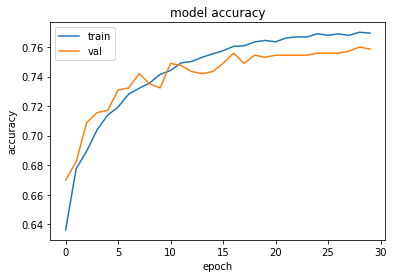

In [256]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()